# Analysis on landcover and building data to support LCZ classification

This NOTEBOOK prepares landcover and building data for later usage in any *LCZ-YEAR* NOTEBOOK

*landcover_buildings_wrangling.py* contains the functions used in this chapter

**Notebook dependencies**

In [4]:
# library import
import pandas as pd 
import geopandas as gpd
import pathlib
import numpy as np
import shapely

import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
from numpy import int16

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [5]:
# Python script import
import landcover_buildings_wrangling

In [6]:
# define year of investigation
#year = 2014
year = 2022

In [7]:
# defining relative paths
NOTEBOOK_DIRECTORY = pathlib.Path().resolve()

DATA_DIRECTORY = NOTEBOOK_DIRECTORY / "data" / f"TLV_{year}"
TABLE_DIRECTORY = NOTEBOOK_DIRECTORY / "output" / "tables"
TEST_DIRECTORY = NOTEBOOK_DIRECTORY / "test"

In [5]:
# importing data
landcover = gpd.read_file(
   DATA_DIRECTORY / f"landcover_{year}.gpkg",
)

#landcover = gpd.read_file('/Users/moritzmuhlbauer/Desktop/landcover_test.gpkg')

buildings = gpd.read_file(
    DATA_DIRECTORY / f"buildings_{year}.gpkg",
)

grid = gpd.read_file(
    '/Users/moritzmuhlbauer/Master Thesis/data/30x30_grid.gpkg'
)

tallinn = gpd.read_file(
    '/Users/moritzmuhlbauer/Master Thesis/data/tallinn_outline/tallinn_dissolved.gpkg',
    layer = 'cleaned'
)

base_raster = rasterio.open('/Users/moritzmuhlbauer/Master Thesis/data/baseline_raster.tif')

## Data Exploration

## Pre Processing

In [6]:
# converting 3D geomtry to 2D
landcover.geometry = shapely.wkb.loads(
        shapely.wkb.dumps(landcover.geometry, output_dimension=2))

buildings.geometry = shapely.wkb.loads(
        shapely.wkb.dumps(buildings.geometry, output_dimension=2))

In [7]:
# applying function to format GeoDataFrames
buildings, landcover, grid = landcover_buildings_wrangling.formating(buildings, landcover, grid)

In [8]:
# cleaning and estimating building height from story number
buildings = landcover_buildings_wrangling.clean_buildings(buildings)

In [9]:
# applying decrypting function
landcover["landcover"], landcover["raster_code"], buildings["type"] = landcover_buildings_wrangling.decrypt(landcover, buildings)

In [10]:
# applying clip function
buildings, landcover = landcover_buildings_wrangling.clip(buildings, landcover, tallinn)

In [11]:
# applying function to extract unique landcovers
transportation, as_with_veg, as_without_veg, ns_without_veg, ns_with_veg, water = landcover_buildings_wrangling.landcover_extract(landcover)

In [12]:
# saving layers to gpkg
landcover_buildings_wrangling.safe_gpkg(transportation, as_with_veg, as_without_veg, ns_without_veg, ns_with_veg, water, landcover, buildings)

**Accuracy + Ratio Assesment** 

In [13]:
landcover_list = [transportation, as_with_veg, as_without_veg, ns_without_veg, ns_with_veg]
overlay_dict = {}
ratio_dict = {}

In [14]:
# calculating area of Tallinn
tallinn['area'] = tallinn.geometry.area

In [15]:
for cover in landcover_list:
    intersection = buildings.overlay(cover, how="intersection", keep_geom_type=True).geometry.area.sum() 
    overlay = ((intersection / (buildings.geometry.area.sum())) * 100).round(2)
    overlay_dict.update({cover.iloc[0, 4]: overlay})

    cover_area = cover.geometry.area.sum()
    ratio = ((cover_area / tallinn.geometry.area.sum()) * 100).round(2)
    ratio_dict.update({cover.iloc[0, 4]: ratio})

accuracy_df = pd.DataFrame(overlay_dict.items(), columns=['Landcover', 'Buildings-Overlay (%)'])
accuracy_df.to_csv(TABLE_DIRECTORY / f'accuracy_assesment_{year}.csv', index=False)

ratio_df = pd.DataFrame(ratio_dict.items(), columns=['Landcover', 'Ratio (%)'])
ratio_df.to_csv(TABLE_DIRECTORY / f'ratio_entire_tallinn_{year}.csv', index=False)

/Users/moritzmuhlbauer/micromamba/envs/gee/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
/Users/moritzmuhlbauer/micromamba/envs/gee/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
/Users/moritzmuhlbauer/micromamba/envs/gee/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
/Users/moritzmuhlbauer/micromamba/envs/gee/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all

## Processing

**Dominant landcover per grid cell**

In [16]:
dominant_landcover = landcover_buildings_wrangling.find_dominant_landcover(landcover, grid)

/Users/moritzmuhlbauer/micromamba/envs/gee/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
/Users/moritzmuhlbauer/micromamba/envs/gee/lib/python3.11/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 2020 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


**Mean building height per grid cell**

In [17]:
mean_building_height = landcover_buildings_wrangling.calculate_mean_building_height(buildings, grid)

/Users/moritzmuhlbauer/micromamba/envs/gee/lib/python3.11/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 45 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


**Built fraction per grid cell**

In [18]:
built_fraction = landcover_buildings_wrangling.calculate_built_fraction(buildings, grid)

/Users/moritzmuhlbauer/micromamba/envs/gee/lib/python3.11/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 45 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


**Rasterize**

In [19]:
landcover_raster = landcover_buildings_wrangling.rasterize_landcover(dominant_landcover, base_raster)

In [20]:
mean_building_height_raster = landcover_buildings_wrangling.rasterize_mean_building_height(mean_building_height, base_raster)

In [21]:
built_fraction_raster = landcover_buildings_wrangling.rasterize_built_fraction(built_fraction, base_raster)

**Difference**

In [43]:
# File paths
bf_2014 = '/Users/moritzmuhlbauer/Master Thesis/output/2014/rasterized/built_fraction.tif'
bf_2022 = '/Users/moritzmuhlbauer/Master Thesis/output/2022/rasterized/built_fraction.tif'
output_fp = TEST_DIRECTORY / "bf_difference.tif"

# Open both rasters
with rasterio.open(bf_2014) as src14, rasterio.open(bf_2022) as src22:
    data_2014 = src14.read(1)
    data_2022 = src22.read(1)

    if data_2014.shape != data_2022.shape:
        raise ValueError("Input rasters must have the same shape and alignment.")

    # Compute absolute change as float
    change = (data_2022 - data_2014).astype(np.float32)

    # Mask where both rasters had 0% built-up
    change[(data_2014 == 0) & (data_2022 == 0)] = np.nan

    # Update profile for float output and nodata
    profile = src22.profile
    profile.update(dtype=rasterio.float32, nodata=np.nan)

    with rasterio.open(output_fp, 'w', **profile) as dst:
        dst.write(change, 1)

print(f"Absolute change raster saved to: {output_fp}")

Absolute change raster saved to: /Users/moritzmuhlbauer/Master Thesis/test/bf_difference.tif


In [9]:
def calculate_difference(data_2014, data_2022, output_fp):
    
    # opening both rasters
    with rasterio.open(data_2014) as src14, rasterio.open(data_2022) as src22:
        _2014 = src14.read(1)
        _2022 = src22.read(1)

        # computing absolute change as float
        change = (_2022 - _2014).astype(np.float32)
    
        # masking where both rasters had 0 
        change[(_2014 == 0) & (_2022 == 0)] = np.nan
    
        profile = src22.profile
        profile.update(dtype=rasterio.float32, nodata=np.nan)

    with rasterio.open(output_fp, 'w', **profile) as dst:
        dst.write(change, 1)

In [10]:
# File paths
bh_2014 = '/Users/moritzmuhlbauer/Master Thesis/output/2014/rasterized/mean_building_height.tif'
bh_2022 = '/Users/moritzmuhlbauer/Master Thesis/output/2022/rasterized/mean_building_height.tif'
output_fp = TEST_DIRECTORY / "bh_difference.tif"

# calling function to calcualte difference in building height
calculate_difference(bh_2014, bh_2022, output_fp)

## Testing

In [22]:
buildings.index.max()

49813

In [23]:
buildings.geometry.isna().sum()

0

In [24]:
one_story = buildings.loc[buildings['stories'] == 1]

In [25]:
one_story.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 31601 entries, 19500 to 42962
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   type_id           31601 non-null  int64   
 1   stories           31601 non-null  float64 
 2   undg_stories      1981 non-null   float64 
 3   material          31598 non-null  object  
 4   height            31601 non-null  int64   
 5   abs_height        31570 non-null  float64 
 6   geometry          31601 non-null  geometry
 7   area              31601 non-null  float64 
 8   height_threshold  31595 non-null  float64 
 9   type              31601 non-null  object  
dtypes: float64(5), geometry(1), int64(2), object(2)
memory usage: 2.7+ MB


In [26]:
smaller_5m_one_story = one_story.loc[one_story.height <= one_story.height.mean()]

In [27]:
smaller_5m_one_story.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 18758 entries, 49035 to 42952
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   type_id           18758 non-null  int64   
 1   stories           18758 non-null  float64 
 2   undg_stories      1336 non-null   float64 
 3   material          18757 non-null  object  
 4   height            18758 non-null  int64   
 5   abs_height        18731 non-null  float64 
 6   geometry          18758 non-null  geometry
 7   area              18758 non-null  float64 
 8   height_threshold  18758 non-null  float64 
 9   type              18758 non-null  object  
dtypes: float64(5), geometry(1), int64(2), object(2)
memory usage: 1.6+ MB


In [28]:
buildings.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 49180 entries, 19500 to 42962
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   type_id           49180 non-null  int64   
 1   stories           49168 non-null  float64 
 2   undg_stories      4785 non-null   float64 
 3   material          49174 non-null  object  
 4   height            49180 non-null  int64   
 5   abs_height        49134 non-null  float64 
 6   geometry          49180 non-null  geometry
 7   area              49180 non-null  float64 
 8   height_threshold  49145 non-null  float64 
 9   type              49180 non-null  object  
dtypes: float64(5), geometry(1), int64(2), object(2)
memory usage: 4.1+ MB


In [29]:
buildings = buildings.loc[buildings['height'] >= 2]
buildings.height.min()

2

In [30]:
buildings.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 49180 entries, 19500 to 42962
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   type_id           49180 non-null  int64   
 1   stories           49168 non-null  float64 
 2   undg_stories      4785 non-null   float64 
 3   material          49174 non-null  object  
 4   height            49180 non-null  int64   
 5   abs_height        49134 non-null  float64 
 6   geometry          49180 non-null  geometry
 7   area              49180 non-null  float64 
 8   height_threshold  49145 non-null  float64 
 9   type              49180 non-null  object  
dtypes: float64(5), geometry(1), int64(2), object(2)
memory usage: 4.1+ MB


<Axes: >

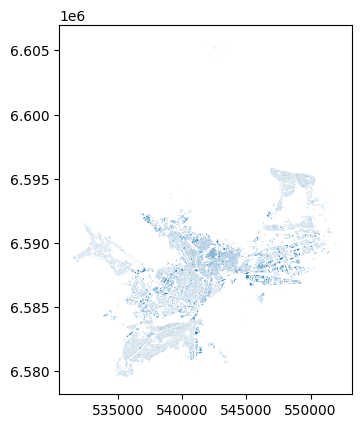

In [31]:
buildings.plot()

In [32]:
buildings.stories.isna().sum()

12

In [33]:
buildings.height.isna().sum()

0

**Estimating Building Height**

<Axes: >

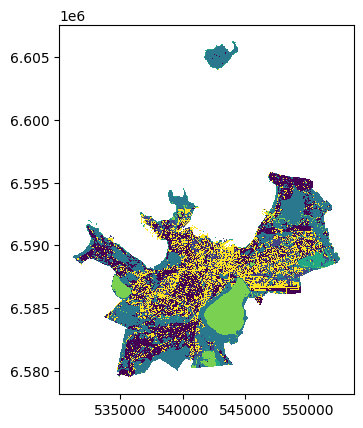

In [34]:
dominant_landcover.plot(column='raster_code')

1. mask out where stories and and height are 0
2. mask out where stories and height are NaNs
3. mask out where height is Na and stories 0?
4. estimate the building height and then delete rows: if height is Na => estimate height 